# Decision Tree

Estudo inicial do comportamento do algoritimo de Arvore de Decisão com essa base de dados.

## Target

Como target inicial, utilizarei a flag 'Is_Internacional' que indicará se uma compra foi feita Reino Unido ou fora dele.

Esse target não tem um impacto direto em um problema de negócio, porém, ao aplicar a Àrvore de Decisão voltada a analisar compras internacionais, poderemos obter novas perspectivas sobre o comportamento dos clientes.

## Importação de Bibliotecas

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder


%matplotlib inline

import os
import sys
sys.path.append(os.path.abspath("../.."))
import notebook_utils as nu
from IPython.display import display, Markdown as display_markdown

nu.setup_notebook()

## Carga

In [94]:
df = pd.read_csv('../assets/data.csv', encoding='ISO-8859-1')

## Pré-processamento

- **Limpeza**: Remoção das linhas sem CustomerID para focar em clientes identificáveis.

- **Target (Is_Cancelled)**: Criação da coluna alvo identificando transações que começam com 'C' no InvoiceNo.

### Engenharia de Features:

- Conversão de datas para extrair mês e hora.

- Correção de Vazamento: Criação de Quantity_Abs. O modelo precisa saber que "comprar 5 itens" tem risco de cancelamento. Se continuasse "-5", ele aprenderia o sinal negativo, o que é inútil para prever risco futuro.

- Normalização dos dados numéricos para atender à rubrica.

In [95]:
df_clean = df.copy()

df_clean = df_clean.dropna(subset=['CustomerID'])

df_clean['Is_Cancelled'] = df_clean['InvoiceNo'].astype(str).str.upper().str.startswith('C').astype(int)

# Feature Engineering
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

df_clean['Quantity_Abs'] = df_clean['Quantity'].abs()
df_clean['TotalAmount'] = df_clean['Quantity_Abs'] * df_clean['UnitPrice']

le = LabelEncoder()
df_clean['Country_Encoded'] = le.fit_transform(df_clean['Country'])

features = ['UnitPrice', 'Quantity_Abs', 'TotalAmount', 'Month', 'Hour', 'Country_Encoded']
X = df_clean[features]
y = df_clean['Is_Cancelled']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=features)

print(f"Distribuição de Cancelamentos:\n{y.value_counts(normalize=True)}")

Distribuição de Cancelamentos:
Is_Cancelled
0    0.978111
1    0.021889
Name: proportion, dtype: float64


## Divisão treino e teste dos dados

Uso do stratify=y porque cancelamentos são eventos raros (classe desbalanceada) e stratify garante que a proporção de cancelamentos seja a mesma no treino e no teste.

In [96]:
# Divisão 70% Treino / 30% Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [97]:
print(f"Dados de Treino: {X_train.shape}")
print(f"Dados de Teste: {X_test.shape}")

Dados de Treino: (284780, 6)
Dados de Teste: (122049, 6)


## Treinamento do modelo

class_weight='balanced': Obriga o modelo a prestar atenção na classe minoritária (os cancelamentos). Sem isso, ele poderia ignorá-los para maximizar a acurácia geral.

max_depth=4: Mantém a árvore simples e interpretável, evitando overfitting.

In [98]:
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    random_state=42,
    class_weight='balanced')

clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


## Teste e Avaliação

### Predição

In [99]:
y_pred = clf.predict(X_test)

### Métricas

In [100]:
print(classification_report(y_test, y_pred, target_names=['Venda Normal', 'Cancelamento']))

              precision    recall  f1-score   support

Venda Normal       0.99      0.74      0.84    119377
Cancelamento       0.05      0.59      0.09      2672

    accuracy                           0.73    122049
   macro avg       0.52      0.67      0.47    122049
weighted avg       0.97      0.73      0.83    122049



### Matriz de Confusão

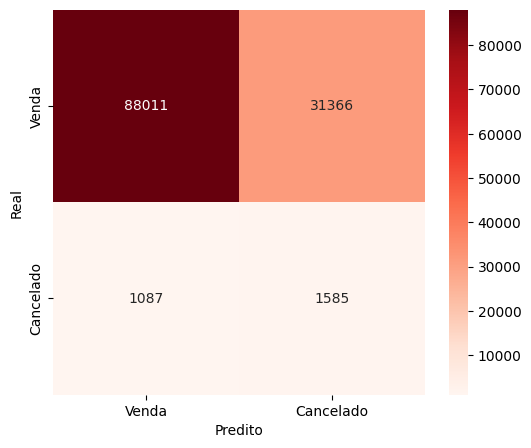

In [101]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Venda', 'Cancelado'], yticklabels=['Venda', 'Cancelado'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()


### Visualização da Árvore

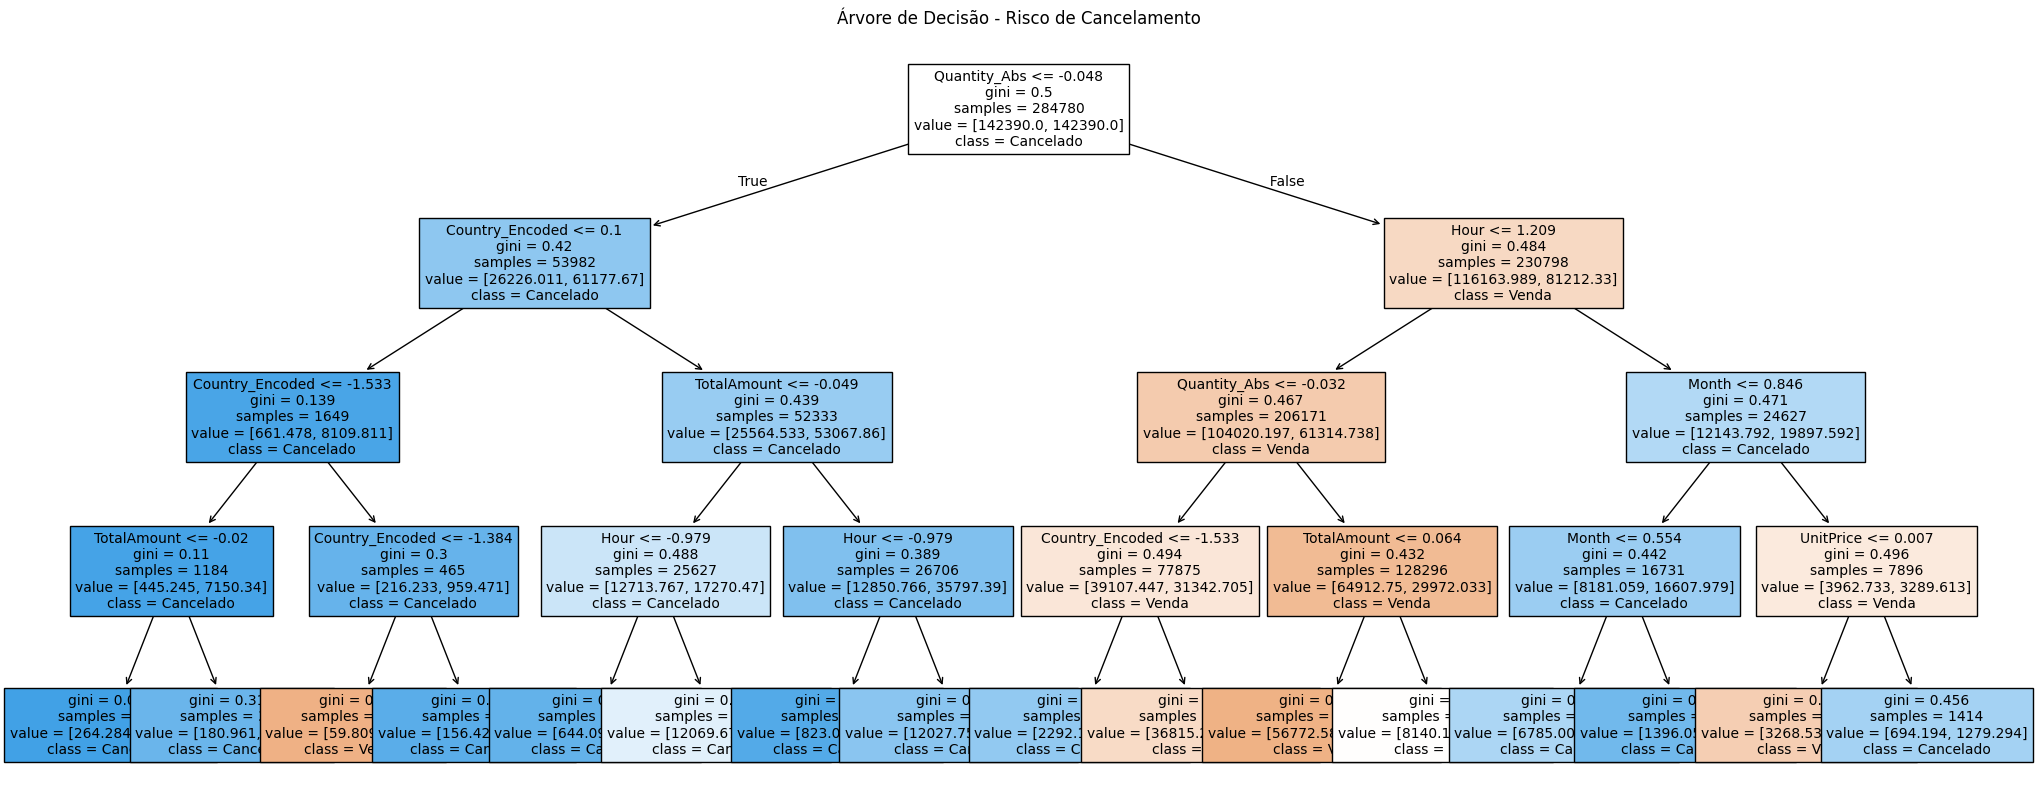

In [102]:
plt.figure(figsize=(25, 10))
plot_tree(clf, feature_names=features, class_names=['Venda', 'Cancelado'], filled=True, fontsize=10)
plt.title("Árvore de Decisão - Risco de Cancelamento")
plt.show()

### Importância das Features

In [104]:
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
print(importances)

Quantity_Abs       0.545769
Hour               0.202847
TotalAmount        0.108878
Country_Encoded    0.097681
Month              0.035014
UnitPrice          0.009811
dtype: float64


## Análise e Interpretação

Acurácia (73.4%): Embora inferior a um modelo base (que teria ~98% apenas prevendo a classe majoritária), esta métrica reflete a decisão de priorizar a detecção da classe minoritária.

Recall (Sensibilidade) da Classe 'Cancelamento' (0.59): O modelo foi capaz de identificar corretamente 59% de todas as transações que resultariam em cancelamento. Para um problema de detecção de risco/fraude, o Recall é frequentemente a métrica mais crítica.

Precision (Precisão) da Classe 'Cancelamento' (0.05): O modelo apresentou uma alta taxa de Falsos Positivos. Isso indica que, para garantir que os cancelamentos fossem detectados, o modelo se tornou "agressivo", classificando muitas vendas normais como risco.

### Conclusão
O modelo atua efetivamente como um filtro de triagem inicial. Embora gere muitos alarmes falsos (baixa precisão), ele captura a maioria dos problemas reais (bom recall).